# Getting started

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import ompy as om
import logging

In [3]:
om.__full_version__

'0.8.0.dev0+8c61c3f'

In [4]:
# For reproducability we seed the random generator. 
# Note that all by default all multinest calculations have a fixed seed in
# ompy, too
np.random.seed(1382398)

In [5]:
# get smaller files for the online version
plt.rcParams["figure.dpi"] = 70

## Loading and example raw spectra

<IPython.core.display.Javascript object>


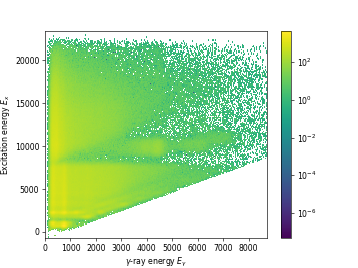

In [6]:
# Import raw matrix into instance of om.Matrix() and plot it
raw = om.example_raw('Dy164')
# To use you own data, uncomment/adapt the line below instead
# raw = om.Matrix(path="/path/to/matrix.ending")

# Plot the entire matrix
raw.plot();

# Note: We use the semi-colon `;` at the end of the line to silence the output
# in jupyter notebook. This is not necessary, but otherwise you get something like 
# this below printed every time:
#(<matplotlib.collections.QuadMesh at 0x7fafbc422eb8>,
# <matplotlib.axes._subplots.AxesSubplot at 0x7fafc0944a20>,
# <Figure size 640x480 with 2 Axes>)

## Matrix manipulation

The core of the Oslo method involves working with two dimensional spectra. Starting with a raw matrix of $E_x$-$E_\gamma$ coincidences, you typically want to unfold the counts
along the gamma-energy axis and then apply the first-generation method to obtain the matrix of first-generation, or primary, gamma rays from the decaying nucleus.

The two most important utility classes in the package are `Matrix()` and `Vector()`. They are used to store matrices (2D) or vectors (1D) of numbers, typically spectra of counts, along with energy calibration information. 

As these underpin the entire package, they contain many useful functions to make life easier. Loading and saving to several formats, plotting, projections, rebinning and cutting, to mention a few. See the documentation for an exhaustive list.

Their basic structure is:

In [7]:
# mat = ompy.Matrix()
mat = raw
mat.values  # A 2D numpy array
mat.Ex      # Array of mid-bin energy values for axis 0 (i.e. the row axis, or y axis)
mat.Eg      # Array of mid-bin energy values for axis 1 (i.e. the column axis, or x axis)

print("The first gamma-ray energies:\n", mat.Eg[0:10])

The first gamma-ray energies:
 [  0.     19.364  38.728  58.092  77.456  96.82  116.184 135.548 154.912
 174.276]


<IPython.core.display.Javascript object>


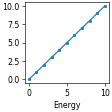

In [8]:
# We can also create a vector, which is useful to store the NLD and gSF.
values = np.arange(11)
E = np.linspace(0, 10, num=11)

fig, ax = plt.subplots(figsize=(2,2), constrained_layout=True)
vec = om.Vector(values=values, E=E)
vec.values  # A 1D numpy array
vec.E       # Array of lower-bin-edge energy values for the single axis
vec.plot(ax=ax);

<IPython.core.display.Javascript object>


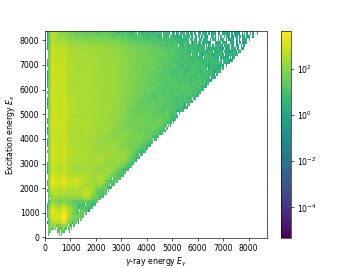

In [9]:
# Cut away counts above the diagonal 
# Remember: Think about what you do here. If you cut them away, they will not
# be used in unfolding etc. This may or may not be what you want.
# Note that the raw matrix we read in above has been cut already, so the difference here is not so large.
raw.cut_diagonal(E1=(800, 0), E2=(7500, 7300))
raw.cut('Ex', 0, 8400)
raw.plot();

Note that `Matrix`, `Vector` and several other classes contain mutable objects. If you work on them, you might want to create a *deepcopy*. For `Matrix`, `Vector` this can be archived by the convince method `X.copy`, otherwise use `copy.deepcopy`.

In [10]:
# The "right" way if you don't want to change the original matrix
raw_big_cut = raw.copy()
raw_big_cut.cut('Ex', 0, 4000)
print(raw.Ex.max(), raw_big_cut.Ex.max())

8300.0 3980.0


In [11]:
# The "wrong" way if you don't want to change the original matrix
raw_big_cut2 = raw_big_cut
raw_big_cut2.cut('Ex', 0, 2000)
print(raw_big_cut.Ex.max(), raw_big_cut2.Ex.max())
# oups!: suddenly also `raw_big_cut` was cut, not only raw_big_cut2

1940.0 1940.0


<IPython.core.display.Javascript object>


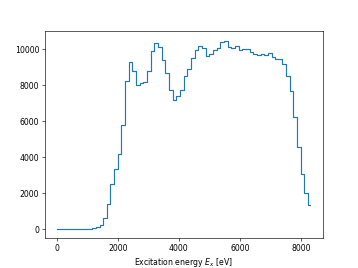

In [12]:
# Plot projections
raw.plot_projection('Ex', Emin=1800, Emax=2600, kind="step");

Note that you can IPython's has tools to quickly access information on a function, namely the `?` character to explore documentation, the `??` characters to explore source code, and the `Tab key` (or `double-tab`) for auto-completion. Try it out uncommenting the function below.

In [13]:
## Uncomment these lines to query a function
# ?raw.plot_projection

## Unfolding

### Get a response matrix

2019-12-03 09:35:14,146 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.
2019-12-03 09:35:17,982 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.


<IPython.core.display.Javascript object>


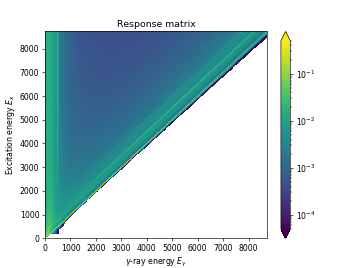

In [14]:
logger = om.introspection.get_logger('response', 'INFO')
# Then do the same using OMpy functionality:
# You may need to adpot this to whereever you response matrixes are stored
folderpath = "../oscar_response/oscar2017_scale1.15"

# Energy calibration of resulting response matrix:
Eg = raw.Eg

# Experimental relative FWHM at 1.33 MeV of resulting array
fwhm_abs = 30 # (30/1330 = 2.25% )

# Magne recommends 1/10 of the actual resolution for unfolding purposes
response = om.Response(folderpath)
R_ompy_view, R_tab_view = response.interpolate(Eg, fwhm_abs=fwhm_abs, return_table=True)
R_ompy_unf, R_tab_unf = response.interpolate(Eg, fwhm_abs=fwhm_abs/10, return_table=True)
R_ompy_view.plot(title="Response matrix", vmin=5e-5, vmax=5e-1,
                 scale="log");



In [15]:
### Perform the unfolding

<IPython.core.display.Javascript object>


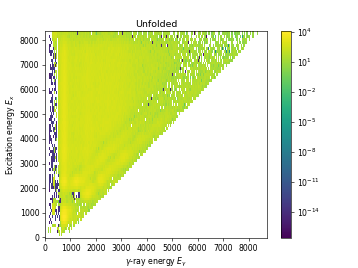

In [16]:
# You can decide to log information and set the logging level (info/debug)
logger = om.introspection.get_logger('unfolder', 'INFO')

# We need to remove negative counts (unphysical) in the raw matrix before unfolding:
raw_positive = raw.copy()
raw_positive.fill_and_remove_negative(window_size=2)

# With compton subtraction and all tweaks
unfolder= om.Unfolder(response=R_ompy_unf)
unfolder.use_compton_subtraction = True # default
unfolder.response_tab = R_tab_unf
# Magne suggests some "tweaks" for a better unfolding performance. Default is 1 for all.
unfolder.FWHM_tweak_multiplier = {"fe": 1., "se": 1.1,
                                     "de": 1.3, "511": 0.9}
unfolded = unfolder(raw_positive)
unfolded.plot();

In [17]:
### Generate the first generation matrix

<IPython.core.display.Javascript object>


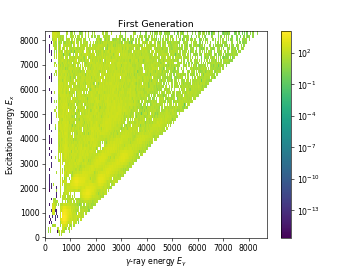

In [18]:
firstgen = om.FirstGeneration()
primary = firstgen(unfolded)
primary.plot();

## Propagating statistical uncertainties

In order to propagate the statistical uncertainties from the raw matrix, we use an ensemble based method. We start of my generating en enseble of *raw-like* matrixes. The raw counts are poisson distributed. If we had counted one another time, we would get slightly different results. 

More precisely, the counts of the matrix containing `prompt+bg` events and the background events `bg` are each poisson distributed, where we have `raw = (prompt+bg) - bg_ratio * bg`. The ratio `bg_ratio` is determined by the ratio of the time gate lengths taken to obtain the `prompt+bg` and `bg` spectra. If a `bg` spectrum is provided to the `Ensemble` class, it will calculate the raw spectrum according to the equaltion above. Otherwise, the provided `raw` spectrum itself is assumed to be poisson distributed.

We take the number of counts $k_i$ in bin $i$ of the raw matrix $R$ as an estimate for the Poisson parameter ("the mean") $λ_i$ . Note that it is an unbiased estimator for $λ_i$, since $E(k) = λ$. To generate a member matrix $R_l$ of the MC ensemble, we replace the counts in each bin $i$ by a random draw from the distribution $\operatorname{Poisson}(k_i)$.

The class Ensemble() provides this feature. Its basic usage is:

In [19]:
logger = om.introspection.get_logger('ensemble', 'INFO')

# Tell the `Ensemble` class which raw spectrum, what kind of undolfer and first
# generations method to use.
# Note: This will have the same setting as above. We could for example have
# set the first generations method to use a different "valley_collection", or a
# differnt type of "multiplicity_estimation"
ensemble = om.Ensemble(raw=raw_positive)
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstgen
# Generates N perturbated members; here just 10 to speed it up
# the `regernerate` flag ensures, that we don't load from disk; which might result in expected results
# if we have changed something in the input `raw` matrix.
ensemble.generate(10, regenerate=True)

2019-12-03 09:35:23,265 - ompy.ensemble - INFO - Generating 0
2019-12-03 09:35:24,537 - ompy.ensemble - INFO - Generating 1
2019-12-03 09:35:25,824 - ompy.ensemble - INFO - Generating 2
2019-12-03 09:35:27,106 - ompy.ensemble - INFO - Generating 3
2019-12-03 09:35:28,363 - ompy.ensemble - INFO - Generating 4
2019-12-03 09:35:29,644 - ompy.ensemble - INFO - Generating 5
2019-12-03 09:35:30,894 - ompy.ensemble - INFO - Generating 6
2019-12-03 09:35:32,177 - ompy.ensemble - INFO - Generating 7
2019-12-03 09:35:33,473 - ompy.ensemble - INFO - Generating 8
2019-12-03 09:35:34,740 - ompy.ensemble - INFO - Generating 9



The generated members are saved to disk and can be retrieved. Unfolded members can be retrieved as `ensemble.get_unfolded(i)`, for example. Their standard deviation is `ensemble.std_unfolded` for the unfolded matrixes, etc.

We can now plot the standard deviation of all ensemble members for the raw, unfolded and first generation spectrum 

<IPython.core.display.Javascript object>


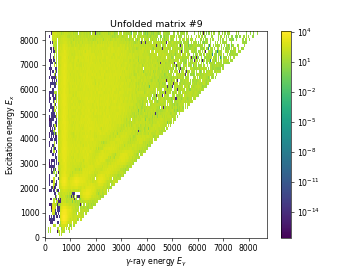

<IPython.core.display.Javascript object>


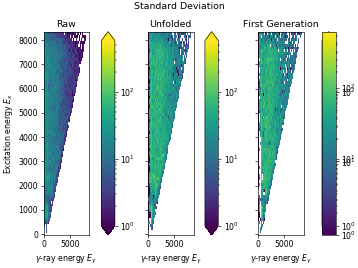

In [20]:
i_unfolded = 9
matrix = ensemble.get_unfolded(i_unfolded)
matrix.plot(title=f"Unfolded matrix #{i_unfolded}")

# Following commands plots all std. deviations
ensemble.plot();

## Extract Nuclear level density and gamma strength function

After matrix has been cut, unfolded and firstgen'd, perhaps ensembled, its nuclear level density (nld) and gamma strength function ($\gamma$SF) can be extracted using the `Extractor()` class.  

The method relies on the relation
 \begin{align}
	P(E_x, E_\gamma) \propto NLD(E_x - E_\gamma) \mathcal{T}(E_\gamma),\label{eq:Oslo_method_eq}
\end{align}
where $P(E_x, E_\gamma)$ is the first-generation spectrum normalized to unity for each $E_x$ bin.  
Furthermore, if we assume that the $\gamma$ decay at high $E_x$ is dominated by dipole radiation the transmission coefficient $\mathcal{T}$ is related to the dipole $\gamma$-ray strength function $f(E_\gamma)$ by the relation
\begin{align}
    \mathcal{T}(E_\gamma) = 2\pi E_\gamma^3 f(E_\gamma).\label{eq:gammaSF}
\end{align} 

If you have reasons to assume a different multipose decomposition, you may of course calculate the transmission coefficient $\mathcal{T}$ from the $\gamma$-ray strength function produced here and apply the decomposition you prefer.

For a single matrix, its usage is:  
(well, think about what you want to set in as the std. deviation)

In [21]:
# cutout = primary.trapezoid(Ex_min=4000, Ex_max=8000, Eg_min=1000, inplace=False)
# cutout_std = ensemble.std_firstgen.trapezoid(Ex_min=4000, Ex_max=8000, Eg_min=1000, inplace=False)
# extractor = om.Extractor()
# nld, gsf = extractor.decompose(cutout, std=cutout_std)

When extracting NLD and GSF from an ensemble, a trapezoidal cutout must be performed on each ensemble member. This is achieved by `Action()` which allows for delayed function calls on matrices and vectors. This way we don't cut the raw matrix at `Ex_min`, but this will only happen before the extraction.

<IPython.core.display.Javascript object>


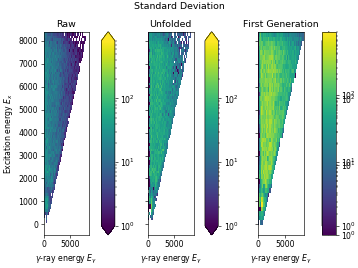

In [22]:
trapezoid_cut = om.Action('matrix')
trapezoid_cut.trapezoid(Ex_min=4000, Ex_max=7000, Eg_min=1000, inplace=True)
extractor = om.Extractor()
extractor.trapezoid = trapezoid_cut
# Running the lines below directy, would most probably 
# result in a error like
# The AssertionError: Ex and Eg must have the same step size
#
# Why? The extraction assumes that Ex and Eg have the same binning. Thus we
# need to rebin the ensemble. This works will work inplace. 
# Note: As always, be careful will mid-bin vs lower bin calibration.
# E_rebinned = ensemble.get_firstgen(0).Ex
# 
E_rebinned = np.arange(100., 8500, 200)
ensemble.rebin(E_rebinned, member="firstgen")
ensemble.plot();

Now we can extract the NLD and $\gamma SF$ for $N$ of the samples of the ensemble.

Note: 
The old software extended the decomposition beyond the `Ex=Eg` line by a resolution `dE`. This is now optional and we changed the default to not do this any longer, but rather assume that the rebinning above has been performed with a binsize of approx. the FWHM of the bin with the worst resolution (usually `(Ex_max, Eg_max)`).

In [23]:
# (here just 8 to speed things up)
extractor.size = 8
extractor.extract_from(ensemble, regenerate=True)

The resulting `nld` and `gsf` are saved to disk and exposed as `extractor.nld` and `extractor.gsf`

<IPython.core.display.Javascript object>


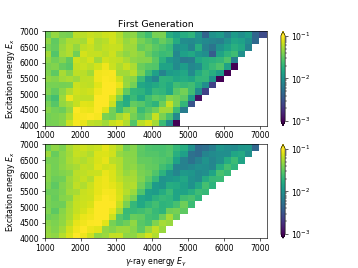

(<matplotlib.collections.QuadMesh at 0x7fd47eb89a90>,
 <Figure size 448x336 with 4 Axes>)

In [24]:
mat = ensemble.get_firstgen(0).copy()
std = ensemble.std_firstgen.copy()
trapezoid_cut.act_on(mat)
trapezoid_cut.act_on(std)
_, _, product = extractor.decompose(mat, std, product=True)
fig, ax = plt.subplots(2,1)
om.normalize_rows(mat.values) 
mat.plot(ax=ax[0], scale="log", vmin=1e-3, vmax=1e-1)
product.plot(ax=ax[1], scale="log", vmin=1e-3, vmax=1e-1)

### Plotting the results before normalization

<IPython.core.display.Javascript object>


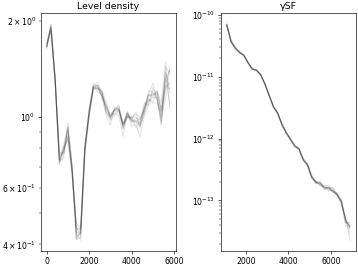

(<Figure size 448x336 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd47eedb8d0>,
       dtype=object))

In [25]:
extractor.plot(plot_mean=False)

Or maybe you are more used to displaying the results with std. deviations?

**Note**: This may be erroneous, as the nld and gsf are not normalized yet!  
Thus, in principal, we might evaluate std. devs. of the *same solution* with different  
transformations. Before we normalize, we don't know. And they have the same $\chi^2$.  
That was the reason for the *trouble* with normalization.



<IPython.core.display.Javascript object>


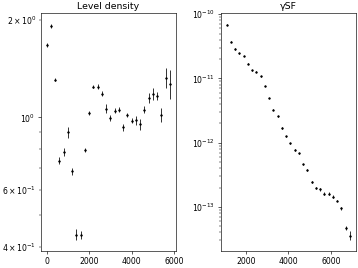

(<Figure size 448x336 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd47f15b898>,
       dtype=object))

In [26]:
extractor.plot(plot_mean=True)

In [27]:
# let's remove the nan-valued elements (unconstrained elements) for the further analysis
nld_mean = extractor.ensemble_nld()
for nld in extractor.nld:
    nld.cut_nan()

for gsf in extractor.gsf:
    gsf.cut_nan()

## Normalization

Does it still look *strange*? probably because you are only used to see the normalized results.

### 1) Manual normalization

<IPython.core.display.Javascript object>


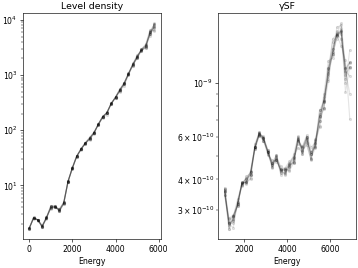

In [28]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_transformed(alpha, A=1, B=1):
    fig, ax = plt.subplots(1, 2, constrained_layout=True)
    for nld, gsf in zip(extractor.nld, extractor.gsf):
        nld.transform(const=A, alpha=alpha, inplace=False).plot(ax=ax[0], scale="log", color='k', alpha=1/10)
        gsf.transform(const=B, alpha=alpha, inplace=False).plot(ax=ax[1], scale="log", color='k', alpha=1/10)
    ax[0].set_title("Level density")
    ax[1].set_title("γSF")

plot_transformed(alpha=0.0015)

### 2) Normalization through external data for one (nld, gsf) set

The normalization ensures that we find the *physical* solution, so we remove the degeneracy that is in principal inherent to decomposition of NLD and $\gamma$SF:
\begin{align}
NLD' = NLD(E_x) * A exp(\alpha E_x) \\
\gamma SF' = \gamma SF(E_\gamma) * B exp(\alpha E_\gamma)
\end{align}
Note: This is the transformation eq (3), Schiller2000.

As external data for the normalization we commonly use:
1. the discrete leves, binned with the resolution of our data (and potentially also smoothed)
2. The NLD at Sn, derived from D0 and a spin distribution
3. The average total radiative width $\Gamma_\gamma$.

#### 1. Sequentially:
Traditionally we have choosen a sequential normalization, where the NLD is normalized first to receive a set $\alpha$. Then we obtain the scaling parameter $B$ of the $\gamma$SF from a normalization to the experimental $\Gamma_\gamma$.

##### nld normalization  
Let's first normalize the mean nld from the extractor.

The normalization will take some time (≲ 30 seconds). The essential output of multinest is saved to disk, and some output is redirected to disk.

In [29]:
normlog = om.introspection.get_logger('normalizer_nld', 'INFO')
nldnorm = om.NormalizerNLD(nld=nld_mean, discrete='../example_data/discrete_levels_Dy164.txt')

In [30]:
norm_pars = om.NormalizationParameters(name="164Dy")
norm_pars.D0 = [6.8, 0.6]  # eV
norm_pars.Sn = [7.658, 0.001] # MeV
norm_pars.spincutModel = 'Disc_and_EB05'  # see eg. Guttormsen et al., 2017, PRC 96, 024313
norm_pars.spincutPars = {"mass":164, "NLDa":18.12, "Eshift":0.31,
                         "Sn": norm_pars.Sn[0], "sigma2_disc":[1.5,3.6]}
norm_pars.Jtarget = 0 # A-1 nucleus

nldnorm.normalize(limit_low=[0, 1.5], limit_high=[3, 5.5], norm_pars=norm_pars)

2019-12-03 09:35:40,161 - ompy.normalizer_nld - INFO - 

---------
Normalizing nld #0
2019-12-03 09:35:40,831 - ompy.normalizer_nld - INFO - DE results:
┌───────────────────┬───────────────────┬────────────────────┬───────────────────┐
│ A                 │ α [MeV⁻¹]         │ T [MeV]            │ D₀ [eV]           │
╞═══════════════════╪═══════════════════╪════════════════════╪═══════════════════╡
│ 4.860186768525463 │ 1.799236041325631 │ 0.5269579947185541 │ 6.867999999999999 │
└───────────────────┴───────────────────┴────────────────────┴───────────────────┘
2019-12-03 09:35:40,832 - ompy.normalizer_nld - INFO - Starting multinest
  analysing data from multinest/nld_norm_0_.txt
2019-12-03 09:36:09,401 - ompy.normalizer_nld - INFO - Multinest results:
┌───────────────┬─────────────────┬─────────────────┬─────────────┐
│ A             │ α [MeV⁻¹]       │ T [MeV]         │ D₀ [eV]     │
╞═══════════════╪═════════════════╪═════════════════╪═════════════╡
│ 4.874 ± 0.025 │ 1.7690 ± 0.002

Observe that the estimated $D_0$ can assume quite *strange*, i.e. unexpected results (posterior mode of $D_0$ is far outside $D_{0,mean} \pm \sigma$). We attribute this to the erroneous determination of the uncertainties in the normalzation using `nld_mean`, instead of the normalization below.

<IPython.core.display.Javascript object>


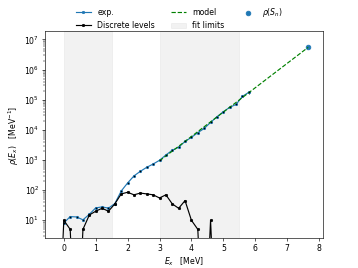

In [31]:
nldnorm.plot();

##### $\gamma$-SF Normalization

In [32]:
normlog = om.introspection.get_logger('normalizer_gsf', 'INFO')
gsfnorm = om.NormalizerGSF(normalizer_nld=nldnorm, gsf=extractor.gsf[0])

# to be use for gsf normalization
norm_pars.Gg = [112., 20.]  #meV

gsfnorm.norm_pars = norm_pars
gsfnorm.model_high.Efit = [4.5, 6.]

2019-12-03 09:36:09,553 - ompy.normalizer_gsf - INFO - Normalizing #0


<IPython.core.display.Javascript object>


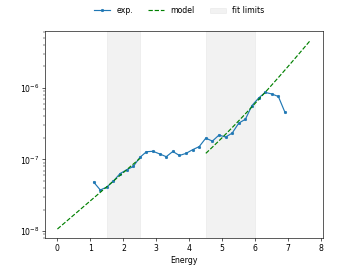

(<Figure size 448x336 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd47c26a8d0>)

In [33]:
gsfnorm.normalize()
gsfnorm.plot()

It's often instructive to plot the extrapolation of the $\gamma$SF; with the interactive code below, we can check the influence of choosing different fit regions. The latest choice is kept for the simultaneous normalization below.

2019-12-03 09:36:09,643 - ompy.normalizer_gsf - INFO - Normalizing #0


<IPython.core.display.Javascript object>


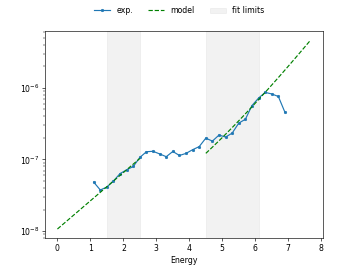

interactive(children=(SelectionRangeSlider(description='Elow', index=(2, 7), options=((1.1, 1.1), (1.3, 1.3), …

In [34]:
gsfnorm.plot_interactive()

#### 2. Simultaneous:
We now propose to normalize the NLD and $\gamma$SF simultaneously instead. This way, we are guaranteed to get matching combinations of the normalization parameters $A$, $B$ and $\alpha$ for a given ensemble member.

In [35]:
simnorm = om.introspection.get_logger('normalizer_simultan', 'INFO')
simnorm = om.NormalizerSimultan(normalizer_nld=nldnorm,
                                      normalizer_gsf=gsfnorm)
simnorm.multinest_kwargs["n_live_points"] = 100 # running faster than the default 400
simnorm.normalize(gsf=extractor.gsf[0], nld=extractor.nld[0])

2019-12-03 09:36:10,690 - ompy.normalizer_nld - INFO - DE results:
┌───────────────────┬────────────────────┬────────────────────┬───────────────────┐
│ A                 │ α [MeV⁻¹]          │ T [MeV]            │ D₀ [eV]           │
╞═══════════════════╪════════════════════╪════════════════════╪═══════════════════╡
│ 4.280972062255931 │ 1.8035697245989804 │ 0.5171019369703203 │ 6.867999999999999 │
└───────────────────┴────────────────────┴────────────────────┴───────────────────┘
2019-12-03 09:36:10,715 - ompy.normalizer_gsf - INFO - Normalizing #0
2019-12-03 09:36:10,721 - ompy.normalizer_simultan - INFO - DE results/initial guess:
┌───────────────────┬────────────────────┬────────────────────┬──────────┬────────────────────┐
│ A                 │ α [MeV⁻¹]          │ T [MeV]            │ D₀ [eV]* │ B                  │
╞═══════════════════╪════════════════════╪════════════════════╪══════════╪════════════════════╡
│ 4.280972062255931 │ 1.8035697245989804 │ 0.5171019369703203 │ 6.8  

<IPython.core.display.Javascript object>


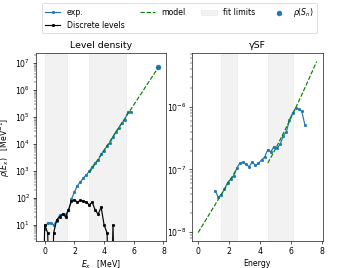

In [36]:
simnorm.plot();

### 3. Normalization the whole ensemble
We have now also developed the toolset to normalize each member of the extractor ensemble separatly. This should provide a statistically more sound and robust normalization. 

Why so? As the $\chi^2$ error function is degenerate, a good minimizer should return sets of (nld, gsf) that need to be normalized with different coefficients $A$, $B$ and $\alpha$. Thus we should normalize each of these sets independently, and build up an uncertainty band only after the normalization. (Instead of the *traditional* approach of normalizing the mean of the sets)

Again, you decide whether you normalize sequencially, or, as we **recommend**, to normalize simultaneously.

Note that this will this may take several minutes!

#### Sequential normalization

In [37]:
normlog = om.introspection.get_logger('ensembleNormalizer', 'INFO')
ensemblenorm = om.EnsembleNormalizer(extractor=extractor, normalizer_nld=nldnorm,
                                     normalizer_gsf=gsfnorm)
ensemblenorm.normalize()

2019-12-03 09:36:29,419 - ompy.ensembleNormalizer - INFO - 

---------
Normalizing #0
2019-12-03 09:36:29,480 - ompy.normalizer_nld - INFO - 

---------
Normalizing nld #0
2019-12-03 09:36:30,103 - ompy.normalizer_nld - INFO - DE results:
┌────────────────────┬───────────────────┬───────────────────┬───────────────────┐
│ A                  │ α [MeV⁻¹]         │ T [MeV]           │ D₀ [eV]           │
╞════════════════════╪═══════════════════╪═══════════════════╪═══════════════════╡
│ 4.2809761655928105 │ 1.803569372461578 │ 0.517101897152072 │ 6.867999999999999 │
└────────────────────┴───────────────────┴───────────────────┴───────────────────┘
2019-12-03 09:36:30,104 - ompy.normalizer_nld - INFO - Starting multinest
  analysing data from multinest/nld_norm_0_.txt
2019-12-03 09:36:44,111 - ompy.normalizer_nld - INFO - Multinest results:
┌─────────────┬───────────────┬─────────────────┬─────────────┐
│ A           │ α [MeV⁻¹]     │ T [MeV]         │ D₀ [eV]     │
╞═════════════╪═══════

2019-12-03 09:38:19,753 - ompy.normalizer_gsf - INFO - Normalizing #0
2019-12-03 09:38:19,760 - ompy.ensembleNormalizer - INFO - 

---------
Normalizing #7
2019-12-03 09:38:19,792 - ompy.normalizer_nld - INFO - 

---------
Normalizing nld #7
2019-12-03 09:38:20,520 - ompy.normalizer_nld - INFO - DE results:
┌────────────────────┬────────────────────┬────────────────────┬───────────────────┐
│ A                  │ α [MeV⁻¹]          │ T [MeV]            │ D₀ [eV]           │
╞════════════════════╪════════════════════╪════════════════════╪═══════════════════╡
│ 4.1340322233051445 │ 1.8389963772453304 │ 0.5252745596427251 │ 6.867999999999999 │
└────────────────────┴────────────────────┴────────────────────┴───────────────────┘
2019-12-03 09:38:20,521 - ompy.normalizer_nld - INFO - Starting multinest
  analysing data from multinest/nld_norm_7_.txt
2019-12-03 09:38:34,860 - ompy.normalizer_nld - INFO - Multinest results:
┌─────────────┬───────────────┬─────────────────┬─────────────┐
│ A   

Observe that there is a rather small difference in the posterior $D_0$'s this time -- although they are towards/just above the edge of the $1\sigma$ of the prior:

In [38]:
print(f"DO: {norm_pars.D0[0]:.2f}\n"
      f"DO - 1𝜎: {norm_pars.D0[0] - norm_pars.D0[1]:.2f}\n"
      f"DO + 1𝜎: {norm_pars.D0[0] + norm_pars.D0[1]:.2f}\n")

DO: 6.80
DO - 1𝜎: 6.20
DO + 1𝜎: 7.40



<IPython.core.display.Javascript object>


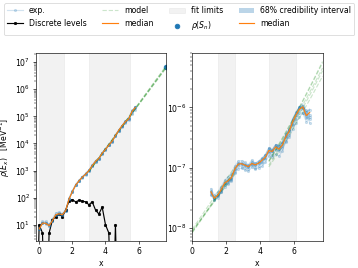

(<Figure size 448x336 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd47ed621d0>,
       dtype=object))

In [39]:
ensemblenorm.plot()

#### Simultaneous normalization

In [40]:
ensemblenorm = om.EnsembleNormalizer(extractor=extractor, normalizer_simultan=simnorm)

ensemblenorm.normalize()

2019-12-03 09:39:05,816 - ompy.ensembleNormalizer - INFO - 

---------
Normalizing #0
2019-12-03 09:39:06,596 - ompy.normalizer_nld - INFO - DE results:
┌───────────────────┬───────────────────┬────────────────────┬───────────────────┐
│ A                 │ α [MeV⁻¹]         │ T [MeV]            │ D₀ [eV]           │
╞═══════════════════╪═══════════════════╪════════════════════╪═══════════════════╡
│ 4.280973828280959 │ 1.803569423726294 │ 0.5171018490658612 │ 6.867999999999999 │
└───────────────────┴───────────────────┴────────────────────┴───────────────────┘
2019-12-03 09:39:06,619 - ompy.normalizer_gsf - INFO - Normalizing #0
2019-12-03 09:39:06,626 - ompy.normalizer_simultan - INFO - DE results/initial guess:
┌───────────────────┬───────────────────┬────────────────────┬──────────┬────────────────────┐
│ A                 │ α [MeV⁻¹]         │ T [MeV]            │ D₀ [eV]* │ B                  │
╞═══════════════════╪═══════════════════╪════════════════════╪══════════╪═════════════

2019-12-03 09:40:29,430 - ompy.normalizer_simultan - INFO - Starting multinest: 
  analysing data from multinest/sim_norm_4_.txt
2019-12-03 09:40:48,282 - ompy.normalizer_simultan - INFO - Multinest results:
┌─────────────┬───────────────┬─────────────────┬─────────────┬─────────┐
│ A           │ α [MeV⁻¹]     │ T [MeV]         │ D₀ [eV]     │ B       │
╞═════════════╪═══════════════╪═════════════════╪═════════════╪═════════╡
│ 4.22 ± 0.16 │ 1.823 ± 0.019 │ 0.5239 ± 0.0056 │ 7.11 ± 0.49 │ 79 ± 16 │
└─────────────┴───────────────┴─────────────────┴─────────────┴─────────┘
2019-12-03 09:40:48,287 - ompy.ensembleNormalizer - INFO - 

---------
Normalizing #5
2019-12-03 09:40:49,067 - ompy.normalizer_nld - INFO - DE results:
┌───────────────────┬────────────────────┬────────────────────┬───────────────────┐
│ A                 │ α [MeV⁻¹]          │ T [MeV]            │ D₀ [eV]           │
╞═══════════════════╪════════════════════╪════════════════════╪═══════════════════╡
│ 4.1907521819828

2019-12-03 09:42:04,750 - ompy.normalizer_gsf - INFO - Normalizing #0
2019-12-03 09:42:04,756 - ompy.normalizer_simultan - INFO - DE results/initial guess:
┌───────────────────┬───────────────────┬────────────────────┬──────────┬────────────────────┐
│ A                 │ α [MeV⁻¹]         │ T [MeV]            │ D₀ [eV]* │ B                  │
╞═══════════════════╪═══════════════════╪════════════════════╪══════════╪════════════════════╡
│ 4.214266317427986 │ 1.821703940148461 │ 0.5222322009588719 │ 6.8      │ 102.40076343348892 │
└───────────────────┴───────────────────┴────────────────────┴──────────┴────────────────────┘
*copied from input
2019-12-03 09:42:04,757 - ompy.normalizer_simultan - INFO - Starting multinest: 
  analysing data from multinest/sim_norm_9_.txt
2019-12-03 09:42:23,539 - ompy.normalizer_simultan - INFO - Multinest results:
┌─────────────┬───────────────┬─────────────────┬─────────────┬─────────┐
│ A           │ α [MeV⁻¹]     │ T [MeV]         │ D₀ [eV]     │ B   

<IPython.core.display.Javascript object>


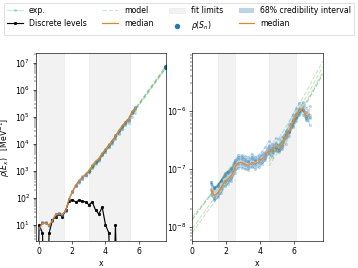

In [41]:
ensemblenorm.plot();